# K-Means Clustering: World's Map
One of fields where KMC algorithm can be applied is demographics.
Imagine a situation, in which you would like to see how people group or would group if all administation divisions or historical conflicts disappeared or ethnical, national or tribal identity would not matter?
How would then people go about creating communities?

In this post, we will use the KMC algorithm to find out how people would group only based on their present geographical distribution.
For this reason we will look at two _parameters_:
* Geographical coordinates,
* Population density at specific location.

As this is a curiosity-driven simulation, it is a great simplification that possesses purely hypothetical character.
The simulation does not take into account conditions such as natural resources or terrain barriers that would prevent people from settling.
Antarctica is the only exception though.
We exclude it, as it is a large part of the map, too large for the algorithm to ignore, yet almost completely unhabitable.

## Dataset
We will use population density dataset available at [NASA](https://neo.sci.gsfc.nasa.gov/view.php?datasetId=SEDAC_POP).
The site offers four versions of the dataset, available in different resolution, which are good for experimentation.

In [1]:
%pylab inline
import pandas as pd
from sklearn.cluster import KMeans

# Supress logarithm zero division warnings.
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

Populating the interactive namespace from numpy and matplotlib


In [2]:
!mkdir dataset
!wget -O dataset/world.csv "https://neo.sci.gsfc.nasa.gov/servlet/RenderData?si=875430&cs=rgb&format=CSV&width=360&height=180"

mkdir: cannot create directory ‘dataset’: File exists
--2020-03-28 00:36:22--  https://neo.sci.gsfc.nasa.gov/servlet/RenderData?si=875430&cs=rgb&format=CSV&width=360&height=180
Resolving neo.sci.gsfc.nasa.gov (neo.sci.gsfc.nasa.gov)... 169.154.132.88, 2001:4d0:2418:132::88
Connecting to neo.sci.gsfc.nasa.gov (neo.sci.gsfc.nasa.gov)|169.154.132.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 459459 (449K) [text/csv]
Saving to: ‘dataset/world.csv’

dataset/world.csv   100%[===================>] 448,69K   292KB/s    in 1,5s    

2020-03-28 00:36:24 (292 KB/s) - ‘dataset/world.csv’ saved [459459/459459]



In [3]:
df = pd.read_csv('./dataset/world.csv', header=None)
df = df.replace(df.max().max(), 0)
df = df.loc[10:145, :]
df = df.reset_index()
df = df.drop(columns=['index'])
df.columns = range(df.shape[1])

For this dataset, the geographical _longitude_ and _latitude_ are simply expressed as integer numbers and treates as _(x, y)_ indices of a matrix, and the map has [cylindrical](https://en.wikipedia.org/wiki/List_of_map_projections#Cylindrical) representation.
At the same time, every element of this matrix represents population density of people living at a particular region.

The oceans are marked as `99999.0`, which is unnatural and thus we put it to zero.
Later, we remove a "strip" of Arctic ocean (just to speed up the computation slightly) and Antarctica, as metioned earlier.
Then, we re-enumerate the indices for rows and columns to have them count from zero.

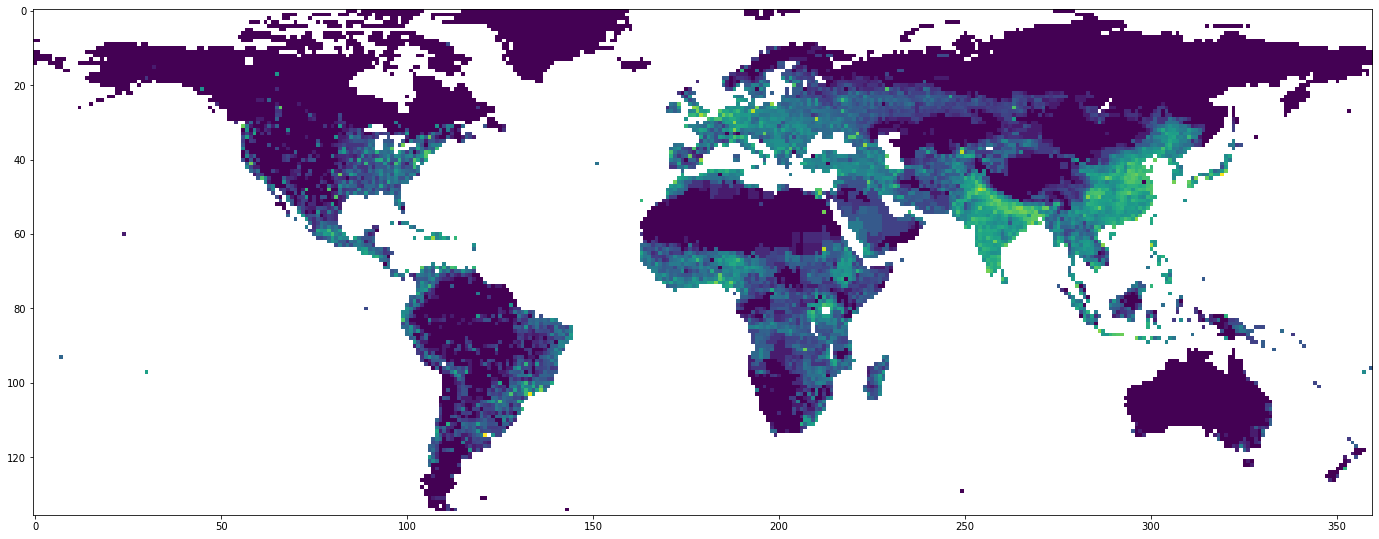

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(24, 24))
ax.imshow(df.apply(lambda x: np.log(x)))

The figure above displays the dataset. The brighter the point, the higher the population density.
Note that we used logarithm to enhance the quality of the image, and the warning comes from taking the logarithm of zero that we assigned for the oceans.

## Feature engineering
Before we proceed, we need to transform our dataset a bit in order to fit in with the clustering problem.
First of all, we need to change the representation of the dataset from a _population density matrix_ to a list of _longitude and latitude coordinate points_, in order for the KMC be able to calculate _distance_.
However, we also need to keep the population density value, which both us and the machine can interpret as _weight_ of each data point.
In other words, large settlements such as big cities will have much stronger tendency to pull the nearest points into the clusters comparing to rural areas or deserts.

In [5]:
latitude_idx = df.index.to_numpy()
longitude_idx = df.columns.to_numpy()

lat_max = len(latitude_idx)
lon_max = len(longitude_idx)

x0 = latitude_idx.repeat(lon_max)
x1 = np.tile(longitude_idx, lat_max)
x  = df.to_numpy()

mask = np.where(x == 0, np.nan, 1)

dd = pd.DataFrame({
    'x0':     x0,
    'x1':     x1,
    'weight': x.flatten()
})

First, we extract the _latitude_ and _longitude_ from the dataframe object.
Then, we repeat the latitude and latitude values, so that they form unique pairs ordered along some new index.
We also dump all the _weights_ and flatten them to a series, which we join into a new dataframe, so we can keep the refernce.
At this point, we define a `mask` for later use when plotting. It will allow us to remove all oceans from the map.

### The world is round...
We know that nowadays people tend to put everything for a debate, but no... the Earth is [still round](https://en.wikipedia.org/wiki/Modern_flat_Earth_societies).
Here, we have a cylindrically represented map, which has an important consequence:
**the left and the right edge of the map are connected together**.
It is therefore vital to ensure that our algorithm will not treat two points residing close to the two edges as very separated.

Because the skearn [API](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit) does not allow us to override the distance metrics easily, we have to parametrize the dataset differently:

In [6]:
dd['latitude']      = (x0 / x0.max() - 0.5) * 2.0
dd['longitude_sin'] = np.sin((x1 / x1.max()) * np.pi * 2.0)
dd['longitude_cos'] = np.cos((x1 / x1.max()) * np.pi * 2.0)

The longitude is the dimention that is _cyclic_, and if we scaled it to an interval of $[0, 2\pi)$, it would literally become the longitudonal angle.
The problem is that the difference between 1st and the 360th degree is 360 degrees, while the _distance_ should be equal to one degree.
Therefore, we can decompose this dimension into two features, and use sine and cosine, respectively.

The latitude should not be cyclic here.
However, if we look at the longitude related features we just defined, we can see that the maximum that can occur along there axes is 2.
Therefore, in order to compensate for it when scaling of latitude, we need to ensure that the maximum distance along it is also 2.

Because our dataframe `dd` keeps all the references, we can simply add the new features into it, which we just did.


## Solution
Now, our feature matrix `X` can be constructed by referecing all points through _latitude_ and the sine/cosine projectins of the _longitude_.
At the same time, we take the population density to act as _weights_.
Before we do that, however, we remove all points whose weight is strickly zero.
As our plane's surface is around 70% water, it can drastically reduce the computation needed.

In [7]:
N_CLUSTERS = 32

dd = dd[dd['weight'] != 0.0]

dd = dd.reset_index()
dd = dd.drop(columns=['index'])

X = dd[['latitude', 'longitude_sin', 'longitude_cos']].to_numpy()
weights = dd['weight'].to_numpy()

dd['cluster'] = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit_predict(X, sample_weight=weights)

The number of clusters is completely arbitrary.
Having solved the KMC problem, we need to "recombine" the solution to the old coordinates, which is fairly easy, given we have kept reference to the original indices.

In [8]:
XX = -1*np.ones((lat_max, lon_max))
for i in range(len(dd)):
    u, v, cluster = dd['x0'].iloc[i], dd['x1'].iloc[i], dd['cluster'].iloc[i]
    XX[u, v] = cluster

Now, let's plot the results.
We will overlay the original population density map with the new "countries".
(NB: The `np.where` function is only used here for enhancing of the plot.)

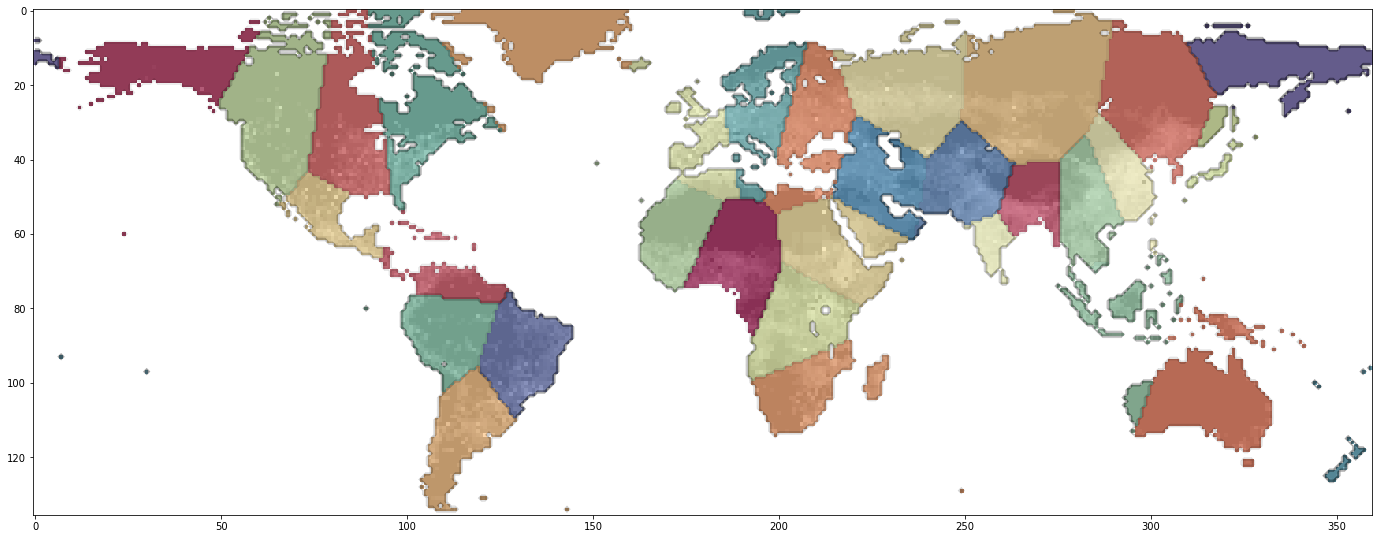

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(24, 24))
ax.imshow(np.where(XX == -1, np.NaN, XX), cmap='Spectral', alpha=0.75)
ax.imshow(df.apply(lambda x: np.log(x)), alpha=0.25, cmap='gray')
ax.contour(longitude_idx, latitude_idx, 
           np.where(XX == -1, -10, XX), 
           levels=N_CLUSTERS, 
           linewidths=0.1, 
           alpha=0.5, 
           colors='k')
plt.show()

### Discussion
We have finally clustered the population.
It is useful to observe the consequences of KMC algorithm's assumptions.

First of all, as we have removed the points of zero weights, no clusters' labels are assinged to those points. However, the larger the population density, the more concentrated the clusters became.
This is especially visible in regions of India and China that are ones of the most densely populated regions in the world. Siberia and Northern parts of Canada, Greenland, Sahara and Australia form larger clusters.

Secondly, by scaling of the features (remember, all features are in range $[-1, 1]$), the clusters do not exhibit anisotropy in any of directions.
In other words, if e.g. the x-axis had 5 times the range, we would expect it's influence to be much stronger and thus the clusterw would be elongated vertically.

Finally, by ensuring the continuity in East-West axis, our clusters are not distorted by presence of the boundary conditions.

## Conclusion
We have seen how K-Means Clustering algorithm can be put into use in our hypothetical world.
However, the usage just demonstrated is actually very traditional, and can be applied in similar situations, giving especially good results when working on smaller maps.
The algorithm helps to spot similarities that exist regardless of any administrative divisions.